In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from itertools import combinations

In [3]:
# Load the kidney disease dataset
kidney_df = pd.read_csv('../data/kidney_disease.csv')

def prepare_kidney_data():
    """
    Prepare the kidney disease dataset for analysis.
    Selects relevant numeric features and handles missing values.
    """
    # Select only numeric columns we want to use
    numeric_cols = ['su', 'bgr', 'sod', 'pot', 'wc', 'bu', 'al', 'rc', 'sc', 'sg', 'pcv', 'hemo']
    kidney_df_clean = kidney_df[numeric_cols + ['classification']]
    
    # Handle missing values
    kidney_df_clean = kidney_df_clean.replace('\t', '', regex=True)
    kidney_df_clean = kidney_df_clean.replace('?', np.nan)
    
    # Drop rows with missing values in the selected columns
    kidney_df_clean = kidney_df_clean.dropna(subset=numeric_cols)
    
    # Convert target variable (ckd = 1, not ckd = 0)
    kidney_df_clean['classification'] = (kidney_df_clean['classification'] == 'ckd').astype(int)
    
    # Prepare features and target
    X = kidney_df_clean[numeric_cols]
    y = kidney_df_clean['classification']
    
    return X, y

# Prepare the data
X_kidney, y_kidney = prepare_kidney_data()
print(f"Dataset shape: {X_kidney.shape}")
print(f"Class distribution: {y_kidney.value_counts()}")

Dataset shape: (208, 12)
Class distribution: classification
0    126
1     82
Name: count, dtype: int64


In [4]:
selected_features = ['bgr', 'pot', 'su', 'wc']
X_selected = X_kidney[selected_features]

# Scale features to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_selected)

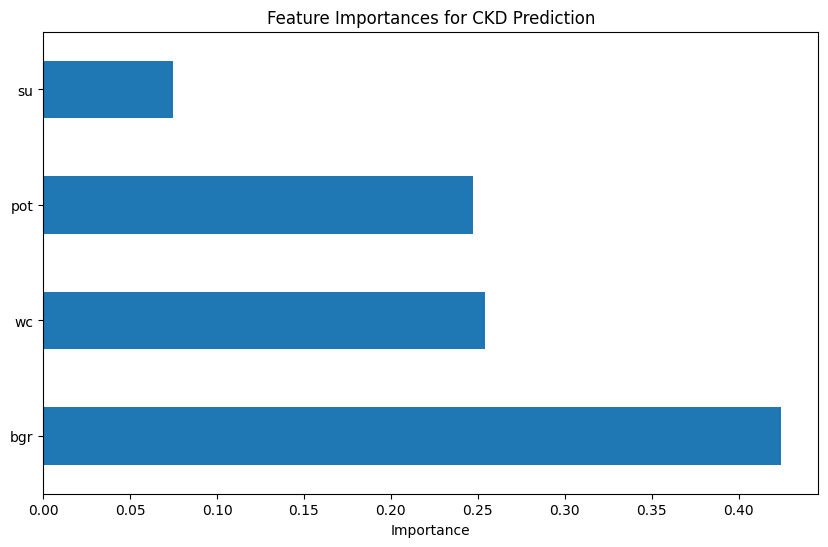

Feature Importance Ranking:
bgr    0.424625
wc     0.253994
pot    0.246985
su     0.074396
dtype: float64


In [5]:
# Calculate feature importance using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y_kidney)

# Create feature importance plot
importances = pd.Series(rf.feature_importances_, index=selected_features)
importances_sorted = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances_sorted.plot(kind='barh')
plt.title('Feature Importances for CKD Prediction')
plt.xlabel('Importance')
plt.show()

print("Feature Importance Ranking:")
print(importances_sorted)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import optuna
import pandas as pd
optuna.logging.set_verbosity(optuna.logging.WARNING)


# please note that optuna runs are not deterministic by default, so the results may vary slightly
def evaluate_single_subset_optuna(X, y, subset_list=None, n_trials=100):
    # Scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    if subset_list is None:
        X_selected = X
    else:
        X_selected = X[subset_list]
    X_scaled = scaler.fit_transform(X_selected)

    # Define objective functions for each model
    def objective_rf(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }
        model = RandomForestClassifier(**params, random_state=42)
        return np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))
    def objective_xgb(trial):
        param = {
            "verbosity": 0,
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 300, 400, 500]),
        }

        if param["booster"] in ["gbtree", "dart"]:
            param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
            param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
            param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        model = xgb.XGBClassifier(**param, random_state=42)
        return np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))

    def objective_lgb(trial):
        params = {
            "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 300, 400, 500, 1000]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }
        model = lgb.LGBMClassifier(**params, random_state=42, verbose=-1)
        return np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))

    def objective_gb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 30),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        }
        model = GradientBoostingClassifier(**params, random_state=42)
        return np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))

    def objective_lr(trial):
        params = {
            'C': trial.suggest_float('C', 1e-5, 1e5, log=True),
            'max_iter': trial.suggest_int('max_iter', 100, 2000),
        }
        model = LogisticRegression(**params, random_state=42)
        return np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))

    def objective_svm(trial):
        params = {
            'C': trial.suggest_float('C', 1e-5, 1e5, log=True),
            'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']),
            'gamma': trial.suggest_float('gamma', 1e-5, 1e2, log=True),
            'degree': trial.suggest_int('degree', 2, 5),
        }
        model = SVC(**params, random_state=42)
        return np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))

    # Optimize each model
    subset_results = {}
    best_params = {}
    
    model_objectives = {
        'Random Forest': objective_rf,
        'XGBoost': objective_xgb,
        'LightGBM': objective_lgb,
        'Gradient Boosting': objective_gb,
        'Logistic Regression': objective_lr,
        'SVM': objective_svm
    }

    for name, objective in model_objectives.items():
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        subset_results[name] = study.best_value
        best_params[name] = study.best_params

    # Find best model
    best_model = max(subset_results, key=subset_results.get)
    
    return {
        'features': ','.join(subset_list),
        'n_features': len(subset_list),
        'best_model': best_model,
        'best_accuracy': subset_results[best_model],
        'best_accuracies': subset_results,
        'best_hyperparameters': best_params
    }

In [ ]:
# 4 features compressed into 2 features with reservoir computing
df_reservoir_v2 = pd.read_csv('../data/reservoir_4set_v2.csv')
X_reservoir_v2 = df_reservoir_v2.drop(columns=['label'])
y_reservoir_v2 = df_reservoir_v2['label']
result_4set = evaluate_single_subset_optuna(X_reservoir_v2, y_reservoir_v2, ['first', 'second'], n_trials=100)
accuracies_df = pd.DataFrame(result_4set['best_accuracies'].items(), columns=['model', 'accuracy'])
accuracies_df.to_excel('reservoir_accuracies_4set_optuna.xlsx', index=False)

In [ ]:
# the top 2 features only in reservoir computing
df_reservoir_raw_v2 = pd.read_csv('../data/reservoir_2set_v2.csv')
X_reservoir_raw_v2 = df_reservoir_raw_v2.drop(columns=['label'])
y_reservoir_raw_v2 = df_reservoir_raw_v2['label']
result_2set = evaluate_single_subset_optuna(X_reservoir_raw_v2, y_reservoir_raw_v2, ['first', 'second'])
accuracies_df = pd.DataFrame(result_2set['best_accuracies'].items(), columns=['model', 'accuracy'])
accuracies_df.to_excel('reservoir_accuracies_2set_optuna.xlsx', index=False)

In [ ]:
td_processed_df = pd.read_csv('../data/kidney_4features_reservoir_input.csv')
X = td_processed_df[['pot', 'bgr', 'su', 'wc']]
y = td_processed_df['target']
# using actual 4 raw features with computer (not fair for reservoir computing)
result_4set_computer = evaluate_single_subset_optuna(X, y, ['pot', 'bgr', 'su', 'wc'])
# using top 2 features with computer
result_2set_computer = evaluate_single_subset_optuna(X, y, ['bgr', 'wc'])
print(result_4set_computer)
print(result_2set_computer)
accuracies_df = pd.DataFrame(result_4set_computer['best_accuracies'].items(), columns=['model', 'accuracy'])
accuracies_df.to_excel('computer_accuracies_4set_optuna.xlsx', index=False)
accuracies_df = pd.DataFrame(result_2set_computer['best_accuracies'].items(), columns=['model', 'accuracy'])
accuracies_df.to_excel('computer_accuracies_2set_optuna.xlsx', index=False)